#### Importing Modules

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import torch
from torch import nn
import torch.nn.functional as F

In [6]:
import sys
sys.path.append("/kaggle/input/segment-anything-zip-file/segment-anything")

In [7]:
import segment_anything as sam

In [8]:
#validation_meta = pd.read_csv(r'/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation_metadata.json')
#train_metadata = pd.read_csv(r'/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json')
sample_submission = pd.read_csv(r'/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv')

#### Configuration

In [9]:
config = {
    'batch_size': 8,
    'learning_rate': 0.001,
    'n_epochs': 10,
    # Add any other hyperparameters you want to track
}

# Use the hyperparameters from the config dictionary
batch_size = config['batch_size']
learning_rate = config['learning_rate']
n_epochs = config['n_epochs']

#### Setting up lazy-loading and preprocessing functions

In [10]:
from torch.utils.data import Dataset, DataLoader

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def getdata(obs_path):
    bands_data = {}

    # Load all band data
    for filename in os.listdir(obs_path):
        if "band" in filename:
            band_name = filename.split('.')[0]  # get the name of the band (excluding the .npy extension)
            file_path = os.path.join(obs_path, filename)  # full path of the file
            band_data = np.load(file_path)  # load the band data
            bands_data[band_name] = band_data  # store the band data in the dictionary
    
    # Load the aggregated contrail markings as labels
    label_path = os.path.join(obs_path, 'human_pixel_masks.npy')
    if os.path.exists(label_path):
        labels = np.load(label_path)
    else:
        labels = None
    return bands_data, labels

def get_ash_color_images(bands_data,get_mask_frame_only = False) -> np.array:
    band11 = bands_data['band_11']
    band14 = bands_data['band_14']
    band15 = bands_data['band_15']
    
    if get_mask_frame_only:
        band11 = band11[:,:,4]
        band14 = band14[:,:,4]
        band15 = band15[:,:,4]

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color

def preprocess_func(bands_data):
    stacked_data = get_ash_color_images(bands_data,get_mask_frame_only = True)
    stacked_data = stacked_data.transpose(2, 0, 1)
    return stacked_data


<font size="4" face="verdana">

| **Band Number** | **Description** | **Additional Details** |
| --- | --- | --- |
| **Band 8** | "Upper-Level Tropospheric Water Vapor" Band | This band is helpful in tracking upper-level atmospheric moisture and jet stream winds, aiding in the forecasting of severe weather events and heavy rainfall. |
| **Band 9** | "Mid-Level Tropospheric Water Vapor" Band | This band captures images of mid-tropospheric moisture and atmospheric motion, valuable for identifying features such as tropical cyclones and thunderstorms. |
| **Band 10** | "Lower-level Water Vapor" Band | The lower-level water vapor band assists in identifying low-level moisture content, aiding in the prediction of fog, frost, and low clouds. |
| **Band 11** | "Cloud-Top Phase" Band | This band helps to determine cloud phases (water, mixed, ice) and heights, crucial for aviation safety and general weather prediction. |
| **Band 12** | "Ozone Band" | The ozone band detects ozone concentration in the atmosphere, offering insights into ozone layer health and aiding in the prediction of UV index and air quality. |
| **Band 13** | "Clean" IR Longwave Window Band | Primarily used for detection of clouds at all levels, sea surface temperature, and rainfall. |
| **Band 14** | IR Longwave Window Band | This band is used for surface and cloud top temperature estimates, identifying cloud types and cloud motion. |
| **Band 15** | "Dirty" Longwave Window Band | Used for estimation of lower-tropospheric water vapor, volcanic ash detection, and for improved rainfall estimation. |
| **Band 16** | "CO2" Longwave Infrared | This band aids in the estimation of cloud height and temperature, especially for high-level clouds. |

</font>

In [11]:
class ContrailsData(Dataset):
    def __init__(self, data_paths, preprocess_func, train_validation):
        # Initialize your data, download, etc.
        self.data_paths = data_paths
        self.preprocess_func = preprocess_func
        self.train_validation = train_validation
    
    def __len__(self):
        return len(self.data_paths['path'])

    def __getitem__(self, index):
        obs_path = self.data_paths.iloc[index]['path']
        bands_data, labels = getdata(obs_path)
        data = self.preprocess_func(bands_data)
        labels = labels.transpose(2, 0, 1)
        labels = torch.from_numpy(labels)
        labels = labels.float()
        return data, labels


def get_data_paths(root_dir):
    all_dirs = []
    for path in os.listdir(root_dir):
        full_path = os.path.join(root_dir, path)
        if os.path.isdir(full_path):
            all_dirs.append(full_path)
    return pd.DataFrame(all_dirs, columns=['path'])

root_dir_train = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
root_dir_validation = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'

train_data_paths = get_data_paths(root_dir_train)
validation_data_paths = get_data_paths(root_dir_validation)

In [12]:
train_dataset = ContrailsData(train_data_paths, preprocess_func, 'train')
validation_dataset = ContrailsData(validation_data_paths, preprocess_func, 'validation')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

#### Defining Models

*  SimpleConv2D
*  UNet
*  Residual Attention Unet

In [14]:
class SimpleConv2D(nn.Module):
    def __init__(self):
        super(SimpleConv2D, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.conv_final = nn.Conv2d(256, 1, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv_final(x)
        
        # Add a Sigmoid activation function as the last layer
        #x = torch.sigmoid(x)
        
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        
        self.upconv5 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv_final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self,x):
        x1 = F.relu(self.conv1(x))
        x = F.max_pool2d(x1,kernel_size=(2))
        
        x2 = F.relu(self.conv2(x))
        x = F.max_pool2d(x2,kernel_size=(2))
        
        x3 = F.relu(self.conv3(x))
        x = F.max_pool2d(x3,kernel_size=(2))
        
        x4 = F.relu(self.conv4(x))
        x = F.max_pool2d(x4,kernel_size=(2))
        
        x5 = F.relu(self.conv5(x))
        
        x6 = torch.cat([x4,self.upconv5(x5)],dim=-3)
        x6 = F.relu(self.conv6(x6))
        
        x7 = torch.cat([x3,self.upconv4(x6)],dim=-3)
        x7 = F.relu(self.conv7(x7))
        
        x8 = torch.cat([x2,self.upconv3(x7)],dim=-3)
        x8 = F.relu(self.conv8(x8))
        
        x9 = torch.cat([x1,self.upconv2(x8)],dim=-3)
        x9 = F.relu(self.conv9(x9))
        
        out=self.conv_final(x9)
        
        return out

### Residual Attention Unet

In [16]:
import torch
import numpy as np
from torch import nn
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, inputChannel, outputChannel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(inputChannel, outputChannel, stride)
        self.bn1 = nn.BatchNorm2d(outputChannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outputChannel, outputChannel)
        self.bn2 = nn.BatchNorm2d(outputChannel)
        self.downsample = downsample
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        caOutput = self.ca(out)
        out = caOutput * out
        saOutput = self.sa(out)
        out = saOutput * out
        return out, saOutput

class BasicDownSample(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )
    
    def forward(self,x):
        x = self.convolution(x)
        return x

class DownSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self,x):
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class BasicUpSample(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        return x
    
class UpSampleWithAttention(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class UNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = BasicDownSample(inputChannel, 32)
    self.downsample2 = BasicDownSample(32, 64)
    self.downsample3 = BasicDownSample(64, 128)
    self.downsample4 = BasicDownSample(128, 256)
    self.downsample5 = BasicDownSample(256, 512)

    self.upsample1 = BasicUpSample(512, 256)
    self.upsample2 = BasicUpSample(512, 128)
    self.upsample3 = BasicUpSample(256, 64)
    self.upsample4 = BasicUpSample(128, 32)
    self.upsample5 = BasicUpSample(64, 32)
    self.classification = self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128 = self.downsample1(x)
    scale64 = self.downsample2(scale128)
    scale32 = self.downsample3(scale64)
    scale16 = self.downsample4(scale32)
    scale8 = self.downsample5(scale16)
    upscale16 = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32 = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64 = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128 = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256 = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class AttentionUNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = DownSampleWithAttention(inputChannel, 32)
    self.downsample2 = DownSampleWithAttention(32, 64)
    self.downsample3 = DownSampleWithAttention(64, 128)
    self.downsample4 = DownSampleWithAttention(128, 256)
    self.downsample5 = DownSampleWithAttention(256, 512)

    self.upsample1 = UpSampleWithAttention(512, 256)
    self.upsample2 = UpSampleWithAttention(512, 128)
    self.upsample3 = UpSampleWithAttention(256, 64)
    self.upsample4 = UpSampleWithAttention(128, 32)
    self.upsample5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.downsample1(x)
    scale64, sa64down = self.downsample2(scale128)
    scale32, sa32down = self.downsample3(scale64)
    scale16, sa64down = self.downsample4(scale32)
    scale8, sa8down = self.downsample5(scale16)
    upscale16, sa16up = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class ResidualAttentionUNet(nn.Module):
  def __init__(self, inputChannel, outputChannel):
    super().__init__()
    self.downsample1 = DownSampleWithAttention(inputChannel, 32)
    self.downsample2 = DownSampleWithAttention(32, 64)
    self.downsample3 = DownSampleWithAttention(64, 128)
    self.downsample4 = DownSampleWithAttention(128, 256)
    self.downsample5 = DownSampleWithAttention(256, 512)

    self.residualBlock1 = ResidualBlock(512, 512)
    self.residualBlock2 = ResidualBlock(512, 512)
    self.residualBlock3 = ResidualBlock(512, 512)

    self.upsample1 = UpSampleWithAttention(512, 256)
    self.upsample2 = UpSampleWithAttention(512, 128)
    self.upsample3 = UpSampleWithAttention(256, 64)
    self.upsample4 = UpSampleWithAttention(128, 32)
    self.upsample5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.downsample1(x)
    scale64, sa64down = self.downsample2(scale128)
    scale32, sa32down = self.downsample3(scale64)
    scale16, sa64down = self.downsample4(scale32)
    scale8, sa8down = self.downsample5(scale16)
    scale8, sa8down = self.residualBlock1(scale8)
    scale8, sa8down = self.residualBlock2(scale8)
    scale8, sa8down = self.residualBlock3(scale8)
    upscale16, sa16up = self.upsample1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upsample2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upsample3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upsample4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upsample5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

#### Training

*  Had to decrease batch size and empty cache because of memory issues. 


In [ ]:
import torch.nn.functional as F
# Define the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize your model
#model = SimpleConv2D().to(device)
#model  = UNet().to(device)
model  = ResidualAttentionUNet(inputChannel = 3, outputChannel = 1).to(device)

# Load the saved model state
#model.load_state_dict(torch.load('ResAttUnet.pth'))

model.load_state_dict(torch.load('/kaggle/input/resattunet-model-state/ResAttUnet.pth'))

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Prepare your data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    batches = 0
    for images, labels in train_dataloader:
        torch.cuda.empty_cache()
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batches+=1
        #print(f'batch:{batches} completed')
        if batches%100 == 0: print(f'batches ran: {batches}')

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print('Train Loss: {:.4f}'.format(epoch_loss))

    # Validation loop
    model.eval()
    with torch.no_grad():
        running_loss = 0
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(validation_dataloader.dataset)
        print('Validation Loss: {:.4f}'.format(epoch_loss))

#### Saving the current state of the model

In [19]:
torch.save(model.state_dict(), 'ResAttUnet.pth')

In [23]:
model.eval()
with torch.no_grad():
    running_loss = 0
    for images, labels in validation_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(validation_dataloader.dataset)
    print('Validation Loss: {:.4f}'.format(epoch_loss))

Validation Loss: 0.0093


### Finding Optimal Dice Coefficient

In [27]:
class Dice(nn.Module):
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.0 *intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
dice = Dice()

class DiceThresholdTester:
    
    def __init__(self, model: nn.Module, data_loader: torch.utils.data.DataLoader):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []
        
    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()
        for images, mask_true in self.data_loader:
            if torch.cuda.is_available():
                images = images.cuda()

            mask_pred = sigmoid(model.forward(images))

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())
            
        self.cumulative_mask_pred = np.concatenate(self.cumulative_mask_pred, axis=0)
        self.cumulative_mask_true = np.concatenate(self.cumulative_mask_true, axis=0)

        self.cumulative_mask_pred = torch.flatten(torch.from_numpy(self.cumulative_mask_pred))
        self.cumulative_mask_true = torch.flatten(torch.from_numpy(self.cumulative_mask_true))
    
    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

In [28]:
dice_threshold_tester = DiceThresholdTester(model, validation_dataloader)
dice_threshold_tester.precalculate_prediction()

In [29]:
thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

optim_threshold = 0.975
best_dice_score = -1

thresholds = []
dice_scores = []

for t in thresholds_to_test:
    dice_score = dice_threshold_tester.test_threshold(t)
    if dice_score > best_dice_score:
        best_dice_score = dice_score
        optim_threshold = t
    
    thresholds.append(t)
    dice_scores.append(dice_score)
    
print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
df_threshold_data = pd.DataFrame({'Threshold': thresholds, 'Dice Score': dice_scores})

Best Threshold: 0.03 with dice: 0.32563108774108424


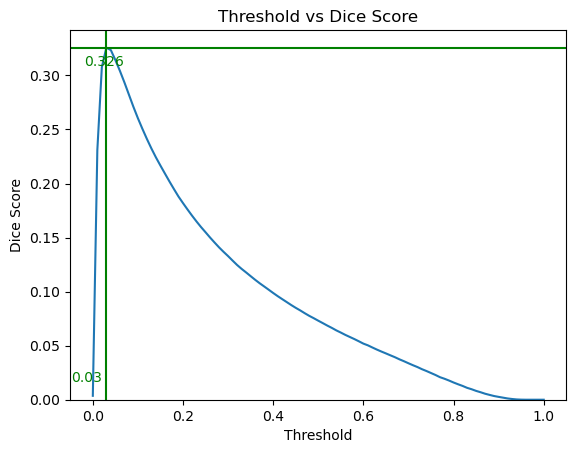

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=df_threshold_data, x='Threshold', y='Dice Score')
plt.axhline(y=best_dice_score, color='green')
plt.axvline(x=optim_threshold, color='green')
plt.text(-0.02, best_dice_score * 0.96, f'{best_dice_score:.3f}', va='center', ha='left', color='green')
plt.text(optim_threshold - 0.01, 0.02, f'{optim_threshold}', va='center', ha='right', color='green')
plt.ylim(bottom=0)
plt.title('Threshold vs Dice Score')
plt.show()